# imports

In [ ]:
import os
path = os.getcwd()

if path[1:5] == 'Home':
    %run /Home/siv30/wad005/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Home/siv30/wad005/master/GRB/src/dau_det_distribution.ipynb
    %run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb

else:
    %run /Users/andreas/phys/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Users/andreas/phys/master/GRB/src/dau_det_distribution.ipynb
    %run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
    %run /Users/andreas/phys/master/GRB//xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
    %run /Users/andreas/phys/master/GRB//xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb
    
from stingray import Lightcurve as LC
from stingray import CrossCorrelation as CC
import numpy as np
import matplotlib.pyplot as plt
import os, re, sys
from astropy.io import fits, ascii
from astropy.time import Time

from gbm.data import TTE,RSP,Trigdat
from gbm.binning.unbinned import bin_by_time
from gbm.plot import Lightcurve, Spectrum
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial #working in ctime for example
%matplotlib inline

#%run /Home/siv30/wad005/useful_py_functions/matplotlib_custom_style_and_macros.py

# Notes
    XSPEC
    -HED is best fit with a cutplep model!
    -KW/FERMI is best fit with Band model. const factor ~1.2 for FERMI
    -KW/FERMI/HED tried fitting with Band model. Got const factor 2.6 for HED and 1.2 for FERMI
    
    

In [79]:
binsize = 0.016 #s

# KW

In [83]:
#importing KW LC

T0_kw = datetime.fromisoformat('2020-07-16T22:57:38.337')
print(f'KW T0: {T0_kw}')
kw_fn = 'GRB200716C_16ms.txt'
kw_df = pd.read_csv(kw_lc_path+kw_fn,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float32), kw_df["Tf"].to_numpy(dtype=np.float32),kw_df["G1"].to_numpy(dtype=np.float32), kw_df["G2"].to_numpy(dtype=np.float32), kw_df["G3"].to_numpy(dtype=np.float32)
kw_df.head()

KW T0: 2020-07-16 22:57:38.337000


,Ti,Tf,G1,G2,G3
0,-0.512,-0.496,20.15,6.02,2.01
1,-0.496,-0.480,14.07,9.03,3.01
2,-0.480,-0.464,11.04,3.02,0.00
3,-0.464,-0.448,20.14,9.04,1.00
4,-0.448,-0.432,19.09,3.01,2.01


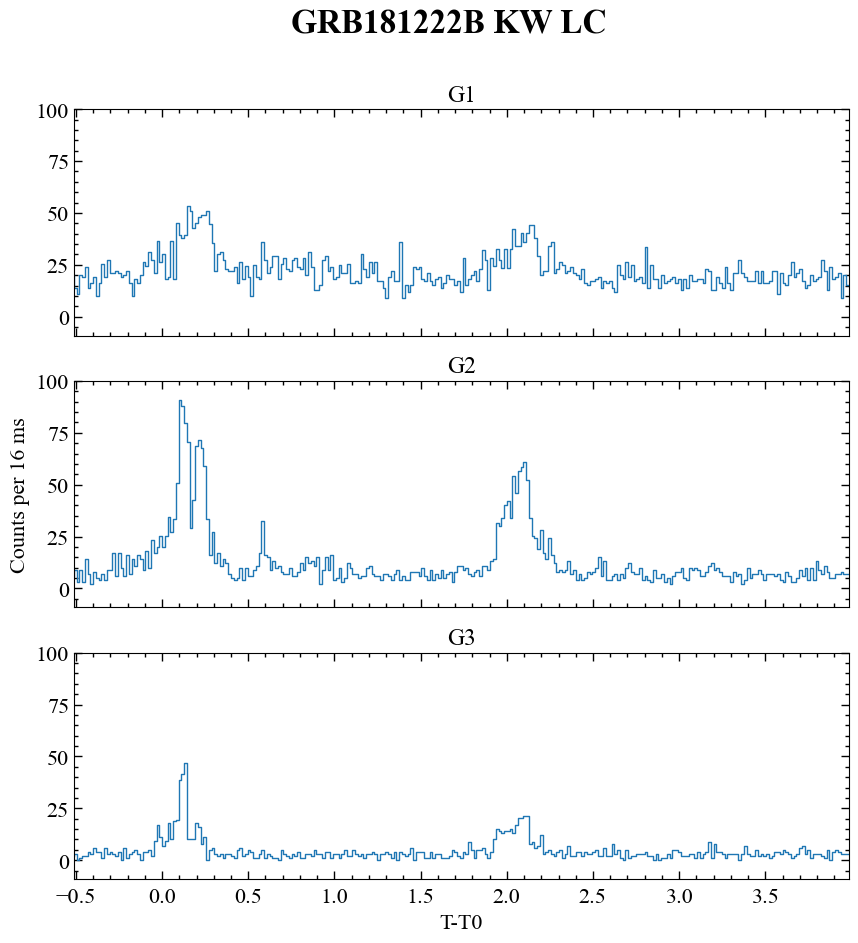

In [84]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharey=True, sharex=True)

kw_dt = np.round(np.diff(kw_bin_lo),3)
jx_kw = np.searchsorted(kw_bin_lo,4)
#jx_kw = np.where(kw_dt>binsize)[0][0] #finding first entry where the binsize increases

# Plot the data for 'G1' in the first subplot
axs[0].step(x=kw_bin_lo[:jx_kw],y=G1[:jx_kw],where='pre')
axs[0].set_title('G1')

# Plot the data for 'G2' in the second subplot
axs[1].step(x=kw_bin_lo[:jx_kw],y=G2[:jx_kw],where='pre')
axs[1].set_title('G2')
axs[1].set_ylabel('Counts per 16 ms')

# Plot the data for 'G3' in the third subplot
axs[2].step(x=kw_bin_lo[:jx_kw],y=G3[:jx_kw],where='pre')
axs[2].set_title('G3')

plt.xlabel('T-T0')
plt.suptitle('GRB181222B KW LC', fontsize=24, fontweight='bold')
plt.show()

In [85]:
kw_dt = np.round(np.diff(kw_bin_lo[:jx_kw]),3)
np.all(kw_dt==binsize)

True

In [86]:
bins = np.append(kw_bin_lo[:jx_kw],kw_bin_lo[jx_kw]) #from -0.512 to 0.512
G1,G2,G3 = G1[:jx_kw],G2[:jx_kw],G3[:jx_kw]

# ASIM
    
    
    GENERAL LOADING OF DATA
    ------------------------------------------------------
    -ref. time: 2020-07-16 22:57:40.634
    
    
    
    
    sp1_4 INTERVAL T0+0.0s --> T0+0.256 
    ------------------------------------------------------
    -HED Safety time: 0.22 % removed
    -ASIM starts at ~T0 and ends at ~T0+s (unshifted)
    -Using bakcground found in this trigger file
    
    
    LARGER INTERVAL
    ------------------------------------------------------
    
    
    
    
    CC
    ------------------------------------------------------
    First or second peak?
    
    
    -eye balling:          s
    -eye balling + KW CC:  s
    -ToF:                  s
    -ASIM + FERMI CC:      s
    
    
    >> tlagg_asim = s seems to be nearly perfect CC
    
    
    
    
    Background
    ------------------------------------------------------
    Using bakground found in another trigger T0~-35 s before burst

    
    
    
    
    xspec
    ------------------------------------------------------

        

In [287]:
df_asim = harvest_data(fn='2020_7_16_22_57_40',T0='2020-07-16T22:57:40.634')
T0_asim = datetime.fromisoformat('2020-07-16T22:57:40.634')
df_asim.head()

dau/det starting from index 1
tus array given in seconds
safety time:  0.22 % removed
sorted by tus (s)


,year,month,day,hour,minute,second,erg,dau,det,datetime,tus,adr,keV,st,dt,flag
0,2020,7,16,22,57,4.835857,1604,2,2,2020-07-16 22:57:04.835856972,-35.798143,5,29709.7941,23.000000,23.194,False
1,2020,7,16,22,57,4.835947,24,3,2,2020-07-16 22:57:04.835947361,-35.798053,8,656.6547,0.313309,0.000,False
2,2020,7,16,22,57,4.836501,94,1,3,2020-07-16 22:57:04.836500861,-35.797499,3,1033.8201,5.045093,553.694,False
3,2020,7,16,22,57,4.836501,92,1,1,2020-07-16 22:57:04.836500889,-35.797499,1,826.0556,2.304222,0.000,False
4,2020,7,16,22,57,4.836501,101,1,2,2020-07-16 22:57:04.836500917,-35.797499,2,2233.9740,2.822649,0.000,False


In [19]:
#ready to CC with KW!

In [288]:
tus_asim = df_asim['tus'].to_numpy()
ix_asim = np.searchsorted(tus_asim,-2)
tus_asim_burst = tus_asim[:ix_asim]
df_asim_burst = df_asim.truncate(before=ix_asim)

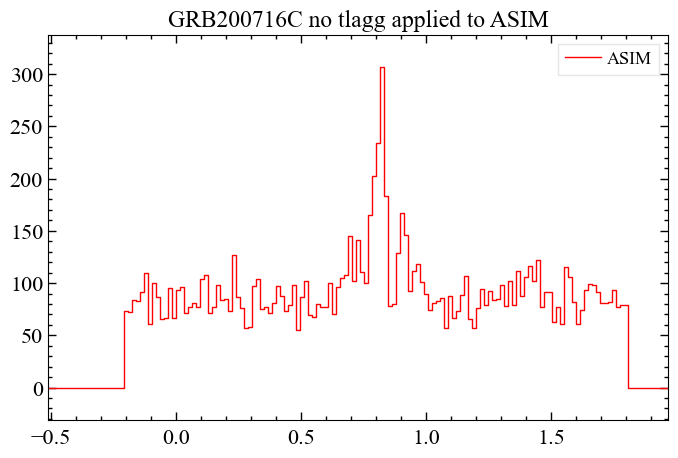

In [290]:
tus_asim_burst = df_asim_burst['tus'].to_numpy()
bins_asim = np.arange(-0.512,2,binsize)
asim_counts, asim_edges = np.histogram(tus_asim_burst, bins=bins_asim)
plt.step(x=asim_edges[:-1], y=asim_counts, where='pre', label='ASIM',c='r')
plt.legend()
plt.title("GRB200716C no tlagg applied to ASIM")
plt.show() #evident that the asim lc must be shifted by ~ -0.6 s

# FERMI
    -tlagg_fermi for n2 seems to be ~ -0.004 s


In [68]:
GRB_id = "GRB200716C"
bn='bn200716957' # GRB id for Fermi
data_dir = path_FERMI_dir + "/" + bn +"/" #setting path to data dir
unit='all' #which units to use. which filenames to open

fn_trigdat = data_dir+'glg_trigdat_'+unit+'_'+bn+'_v01.fit' #check of its a different v01.fit

trigdat = Trigdat.open(fn_trigdat)
print(trigdat)
print(trigdat.trigtime)


# Once extracted, it has the full capabilities of the [```Ctime```](./PhaiiData.ipynb) class.  You can also retrieve the sum of the detectors:
# the triggered detectors
trig_dets = trigdat.triggered_detectors
print(trig_dets)

grb_ra, grb_dec = 196.01,29.636 #put in manually

all_dets=np.array(['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','na','nb','b0','b1'])
point_dets = np.zeros(shape=(all_dets.size,2))
for i in range(all_dets.size):
    point_dets[i,:] = trigdat.detector_pointing(all_dets[i], trigdat.trigtime)

#Q: Finding out where each detector is pointing and storing in a 14x2 matrix?
# ra, dec?

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Print dets with increasing angular separation from the GRB position
idx_sort_angsep = np.argsort(ang_sep) #sorting in increasing order
for i in idx_sort_angsep:
    print(all_dets[i],round(ang_sep[i],3))
    
#print(all_dets[idx_sort_angsep]) #sorting
#print(ang_sep[idx_sort_angsep]) #sorting


#The detectors nearest to the burst are listed first. If the degree is more than 60 deg, be careful to use the response function


glg_trigdat_all_bn200716957_v01.fit
616633066.180458
['n0', 'n1']
n1 9.184
n0 16.203
n9 53.364
n2 54.003
n6 57.053
n3 58.164
n5 65.566
b0 67.377
na 80.761
n7 82.75
n4 100.137
b1 112.623
nb 114.716
n8 126.356


In [22]:
print(f'lat {np.round(trigdat.get_latitude(trigdat.trigtime),4)}')
print(f'lon: {np.round(trigdat.get_longitude(trigdat.trigtime),4)}')
print(f'alt: {np.round(trigdat.get_altitude(trigdat.trigtime)/1e3,4)} km')

lat 3.4447
lon: 346.7213
alt: 521.4685 km


In [39]:
trigdat.trigtime

616633066.180458

In [41]:
print(f'MET: {trigdat.trigtime}')
T0_fermi = datetime.fromisoformat('2020-07-16 22:57:41.180')
print(f'UTC: {T0_fermi}')

MET: 616633066.180458
UTC: 2020-07-16 22:57:41.180000


In [260]:
unit = all_dets[idx_sort_angsep][7] #for selecting the detector that are have the lowest incident angle to the GRB
#unit = trig_dets[1] #unit of the first trigger detector. What unit is this?
print(unit)

fn_tte = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'
fn_rsp = data_dir+'glg_cspec_'+unit+'_'+bn+'_v02.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels

b0


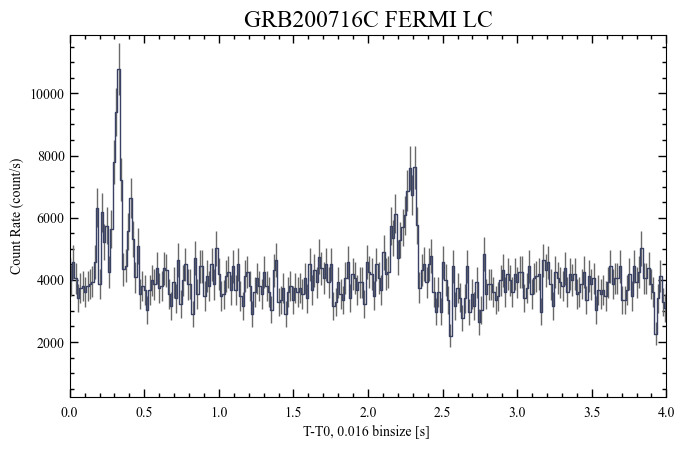

In [261]:
# open a TTE file
tte = TTE.open(fn_tte)

#bin_by_time is defined in imports. now have the spectra for each bin 
phaii = tte.to_phaii(bin_by_time,0.016,time_ref=0.0) #puls height amplitude of second type ii. i: sum along columns, ii: for all channels

erange = (350,1e5)
lc_data = phaii.to_lightcurve(energy_range=erange)
lcplot = Lightcurve(data=lc_data)
lcplot.xlim = (0,4)#(bins[0],bins[-1])
lcplot.ax.set_title(f'GRB200716C FERMI LC')
lcplot.ax.set_xlabel(f'T-T0, {binsize} binsize [s] ')
#plt.savefig(fname='/Users/andreas/phys/master/GRB/pyplots/GRB211211A_FERMI_LC.png')
plt.show()

# CC

## KW / FERMI cc

In [250]:
# applying the ToF

tof_kw_asim = 3.0155 # reached ISS first
tof_asim_fermi = 0.0109 #reaced ISS first
T0_fermi_shift = T0_kw + timedelta(seconds=tof_kw_asim+tof_asim_fermi)
print(f'T0_fermi:       {T0_fermi}')
print(f'T0_fermi_shift: {T0_fermi_shift}')

tlagg_fermi_approx = (T0_fermi-T0_fermi_shift).total_seconds()
print(f'fermi_tlagg: {tlagg_fermi_approx} s. apply to tus_fermi')

T0_fermi:       2020-07-16 22:57:41.180000
T0_fermi_shift: 2020-07-16 22:57:41.363400
fermi_tlagg: -0.1834 s. apply to tus_fermi


In [251]:
# fermi bkg estimation
tus_fermi = tte.data.time + tlagg_fermi_approx

i_bkg,j_bkg = find_nearest(tus_fermi,-80),find_nearest(tus_fermi,-20)
tus_fermi_bkg = tus_fermi[i_bkg:j_bkg]

fermi_bkg_c,fermi_bkg_e = np.histogram(tus_fermi_bkg,bins=np.arange(min(tus_fermi_bkg),max(tus_fermi_bkg)+binsize,binsize))
fermi_mean_bkg = np.round(np.mean(fermi_bkg_c),4)
print(fermi_mean_bkg)

20.6445


In [252]:
#fermi
tus_fermi = tte.data.time + tlagg_fermi_approx
fermi_ix,fermi_jx = np.searchsorted(tus_fermi,bins[0]), np.searchsorted(tus_fermi,bins[-1])
tus_fermi = tus_fermi[fermi_ix:fermi_jx]
fermi_counts,fermi_edges = np.histogram(tus_fermi,bins=bins)
#fermi_counts = np.maximum(fermi_counts - fermi_mean_bkg, 0)

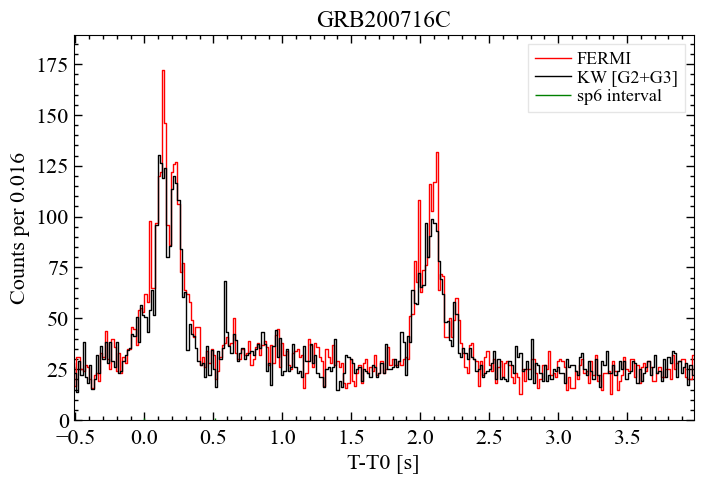

In [253]:
plt.step(x=bins[:-1],y=fermi_counts,c='r',where='pre',label='FERMI')
plt.step(x=bins[:-1],y=(G1+G2),c='black',where='pre',label='KW [G2+G3]')
plt.vlines(x=[0.000,0.256],ymin=0,ymax=1.1,color='green',label='sp6 interval')
plt.ylim(bottom=0.0)
plt.legend()
plt.title('GRB200716C')
plt.xlabel('T-T0 [s]')
plt.ylabel(f'Counts per {binsize}')
plt.show()

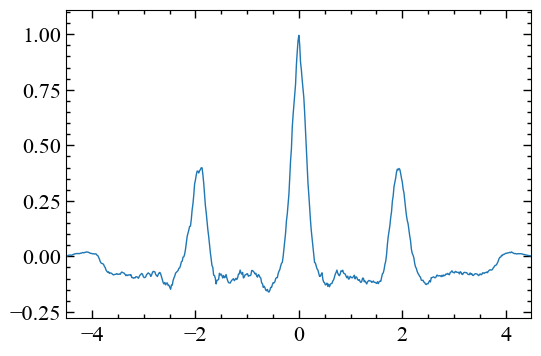

0.0


In [255]:
fermi_lc = LC(time=bins[:-1]+binsize/2,counts=fermi_counts,dt=binsize,skip_checks=True)
kw_lc = LC(time=bins[:-1]+binsize/2,counts=G1+G2,dt=binsize,skip_checks=True)

CC_fk = CC(kw_lc,fermi_lc,mode='full',norm='variance')
CC_fk.plot()
tlagg_fermi = CC_fk.time_shift 
print(tlagg_fermi)

-0.1834

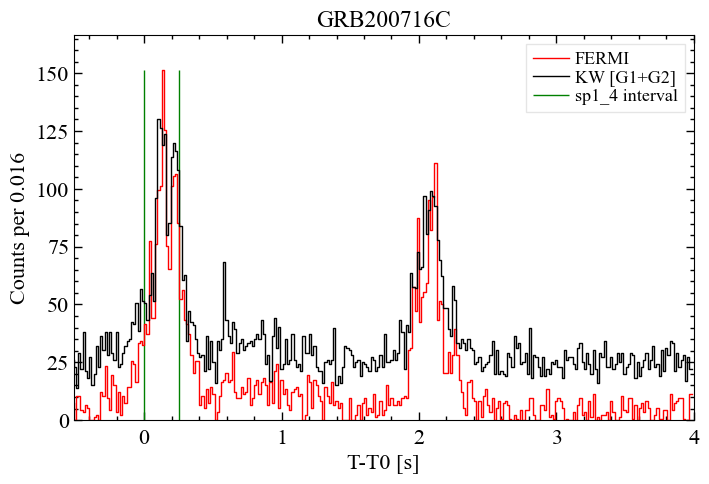

In [256]:
#fermi
tlagg_fermi = CC_fk.time_shift + tlagg_fermi_approx
tus_fermi = tte.data.time + tlagg_fermi
fermi_ix,fermi_jx = np.searchsorted(tus_fermi,bins[0]), np.searchsorted(tus_fermi,bins[-1])
tus_fermi = tus_fermi[fermi_ix:fermi_jx]
fermi_counts,fermi_edges = np.histogram(tus_fermi,bins=bins)
fermi_counts = np.maximum(fermi_counts - fermi_mean_bkg, 0)

plt.step(x=bins[:-1],y=fermi_counts,c='r',where='pre',label='FERMI')
plt.step(x=bins[:-1],y=(G1+G2),c='black',where='pre',label='KW [G1+G2]')
plt.vlines(x=[0.00,0.256],ymin=0,ymax=max(fermi_counts),color='green',label='sp1_4 interval')
plt.ylim(bottom=0.0)
plt.xlim(left=-0.512,right=4)
plt.legend()
plt.title('GRB200716C')
plt.xlabel('T-T0 [s]')
plt.ylabel(f'Counts per {binsize}')
plt.show()

## KW / ASIM cc

In [119]:
T0_asim_approx = T0_kw + timedelta(seconds=tof_kw_asim)
tlagg_approx_asim = (T0_asim-T0_asim_approx).total_seconds()
print(T0_asim)
print(T0_asim_approx)
print(f'asim tlagg estimation: {tlagg_approx_asim} s. apply to tus_asim')

2020-07-16 22:57:40.634000
2020-07-16 22:57:41.352500
asim tlagg estimation: -0.7185 s. apply to tus_asim


In [268]:
tlagg_approx_asim = -0.7185

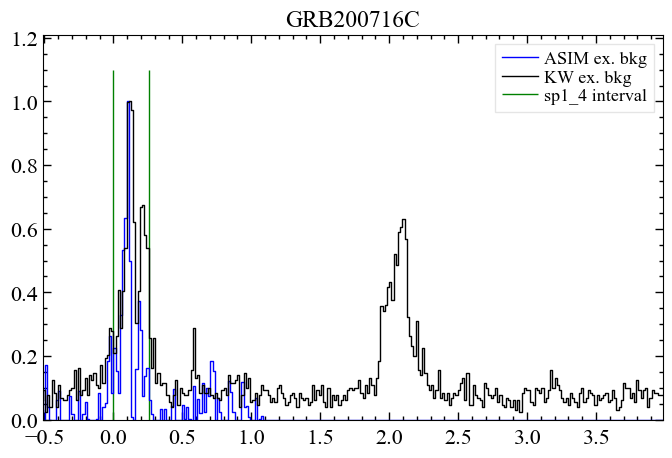

In [270]:
tus_asim = tus_asim_burst + tlagg_approx_asim

asim_counts, asim_edges = np.histogram(tus_asim, bins=bins)
asim_jx = np.searchsorted(asim_edges, -0.15)
asim_counts = np.maximum(asim_counts - np.mean(asim_counts[:asim_jx]), 0)

plt.step(x=bins[:-1], y=asim_counts/max(asim_counts), where='pre', label='ASIM ex. bkg',c='blue')
plt.step(x=bins[:-1],y=(G2+G3)/max(G2+G3),where='pre',label='KW ex. bkg',c='black')
plt.vlines(x=[0.0,0.256],ymin=0,ymax=1.1,label='sp1_4 interval',color='g')
#plt.xlim(left=0.1, right=0.3)
plt.ylim(bottom=0.0)
plt.title("GRB200716C")
plt.legend()
plt.show() #evident that the asim lc must be shifted by ~ -0.6s

In [271]:
asim_lc = LC(time=asim_edges[:-1]+binsize/2,counts=asim_counts,skip_checks=True)
kw_lc = LC(time=bins[:-1]+binsize/2,counts=G3,skip_checks=True)
np.all(asim_lc.bin_lo == kw_lc.bin_lo)

True

tlagg_asim: 0.016000032424926758


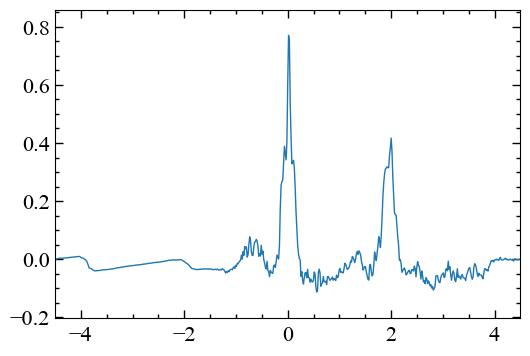

In [272]:
CC_kw_asim = CC(kw_lc,asim_lc,mode='full',norm='variance')
tlagg_asim = CC_kw_asim.time_shift
print(f'tlagg_asim: {tlagg_asim}')
CC_kw_asim.plot()
plt.show()

In [273]:
print(np.round(tlagg_asim + tlagg_approx_asim,4))

-0.7025


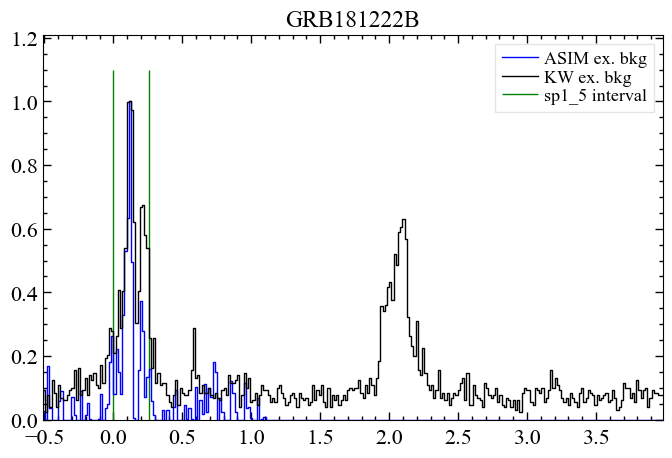

In [275]:
tus_asim_shifted = df_asim_burst['tus'].to_numpy() + tlagg_asim + tlagg_approx_asim

asim_counts, asim_edges = np.histogram(tus_asim_shifted, bins=bins)
asim_jx = np.searchsorted(asim_edges, -0.15)
asim_counts = np.maximum(asim_counts - np.mean(asim_counts[:asim_jx]), 0)

plt.step(x=bins[:-1], y=asim_counts/max(asim_counts), where='pre', label='ASIM ex. bkg',c='blue')
plt.step(x=bins[:-1],y=(G2+G3)/max(G2+G3),where='pre',label='KW ex. bkg',c='black')
plt.vlines(x=[0.0,0.256],ymin=0,ymax=1.1,label='sp1_5 interval',color='g')
#plt.xlim(left=-0.256, right=0.6)
#plt.xlim(left=0.1, right=0.3)
plt.ylim(bottom=0.0)
plt.title("GRB181222B")
plt.legend(loc='upper right')
plt.show() #evident that the asim lc must be shifted by ~ -0.6s

## ASIM / FERMI cc

In [134]:
tte = TTE.open(fn_tte)
tus_fermi = tte.data.time #+ tlagg_fermi
print(f'tlagg fermi: {tlagg_fermi}')
phaii = tte.to_phaii(bin_by_time,0.002,time_ref=0.0)
erange = (500,4e4)
lc_data = phaii.to_lightcurve(energy_range=erange)

tlagg fermi: 0.0008


In [135]:
tus_asim = df_asim_burst['tus'].to_numpy() + tlagg_approx_asim
i,j = np.searchsorted(tus_fermi,min(tus_asim)), np.searchsorted(tus_fermi,max(tus_asim))
tus_fermi_burst = tus_fermi[i:j]

In [136]:
fermi_lc = LC.make_lightcurve(toa=tus_fermi_burst,dt=0.002)
asim_lc = LC.make_lightcurve(toa=tus_asim,dt=0.002)

-0.008


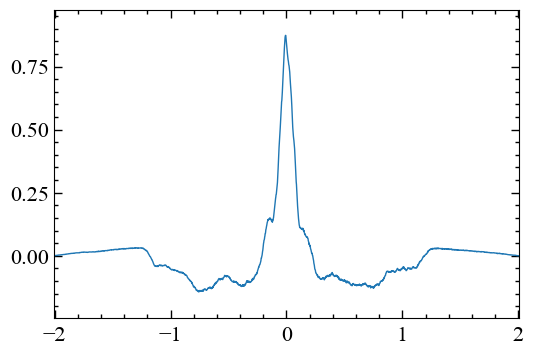

In [137]:
CC_fa = CC(fermi_lc,asim_lc,mode='full',norm='variance')
asim_shift_lc = asim_lc.shift(CC_fa.time_shift)
print(CC_fa.time_shift)
CC_fa.plot()
plt.show()

In [139]:
print(CC_fa.time_shift+ tlagg_approx_asim)

-0.438


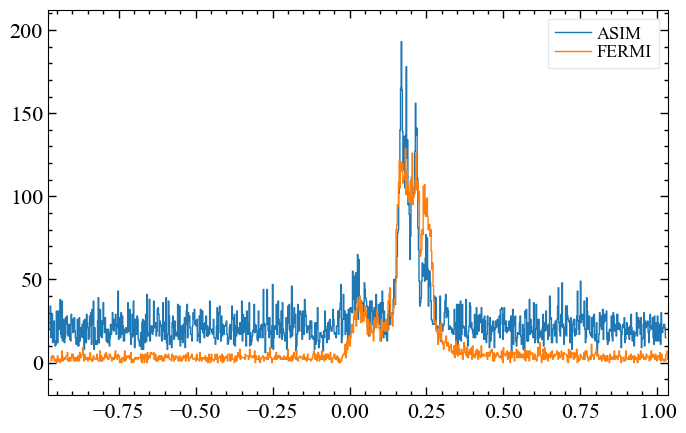

In [140]:
plt.step(x=asim_shift_lc.bin_lo, y=asim_shift_lc.counts,where='pre',label='ASIM')
plt.step(x=fermi_lc.bin_lo, y=fermi_lc.counts,where='pre',label='FERMI')
plt.legend()
plt.show()

# SUPERPLOT

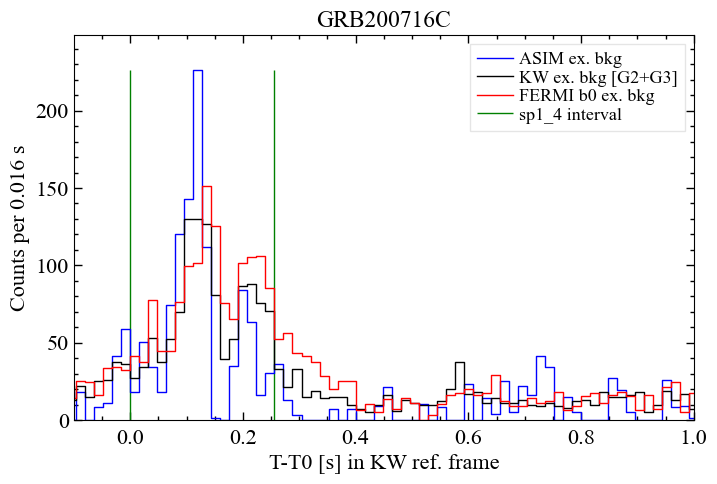

In [276]:
plt.step(x=bins[:-1], y=asim_counts, where='pre', label='ASIM ex. bkg',c='blue')
plt.step(x=bins[:-1],y=(G2+G3),where='pre',label='KW ex. bkg [G2+G3]',c='black')
plt.step(x=bins[:-1],y=fermi_counts,where='pre',label=f'FERMI {unit} ex. bkg',c='r')
plt.vlines(x=[0.0,0.256],ymin=0,ymax=max(np.concatenate([(G2+G3).astype(np.int32), fermi_counts.astype(np.int32), asim_counts.astype(np.int32)])),
           color='green',label='sp1_4 interval')
plt.ylim(bottom=0.0)
plt.xlim(left=-0.1,right=1)
plt.legend(loc='best')
plt.ylabel(f'Counts per {binsize} s')
plt.xlabel('T-T0 [s] in KW ref. frame')
plt.title('GRB200716C')
#plt.savefig('/Users/andreas/Desktop/meeting_plots/GRB200716C_superplot.png', dpi=300, bbox_inches='tight', format='png')
plt.show() #evident that the asim lc must be shifted by ~ -0.6s

# Extraction of FITS files

## ASIM extraction

In [291]:
tlagg_asim = -0.7025
df_asim_burst['tus'] += tlagg_asim
T0_asim += timedelta(seconds=tlagg_asim)
print(T0_asim)
df_asim_burst.head()

2020-07-16 22:57:39.931500


,year,month,day,hour,minute,second,erg,dau,det,datetime,tus,adr,keV,st,dt,flag
9564,2020,7,16,22,57,40.446954,493,2,1,2020-07-16 22:57:40.446953557,-0.889546,4,4958.7259,18.834904,3.360371e+07,False
9565,2020,7,16,22,57,40.44709,57,1,1,2020-07-16 22:57:40.447089502,-0.889410,1,520.1671,1.080668,3.360941e+07,False
9566,2020,7,16,22,57,40.44709,20,3,3,2020-07-16 22:57:40.447089585,-0.889410,9,492.0033,0.000000,3.360890e+07,False
9567,2020,7,16,22,57,40.447281,18,3,1,2020-07-16 22:57:40.447280919,-0.889219,7,418.8321,0.188321,3.360212e+07,False
9568,2020,7,16,22,57,40.447479,1677,4,1,2020-07-16 22:57:40.447479474,-0.889021,10,28938.5216,23.000000,3.360327e+07,False


In [292]:
tus_asim = df_asim_burst['tus'].to_numpy() 
ix_asim, jx_asim = np.searchsorted(tus_asim,0), np.searchsorted(tus_asim,0.256)
df_burst_final = df_asim_burst.truncate(before=df_asim_burst.index[0]+ix_asim, after=df_asim_burst.index[0]+jx_asim)

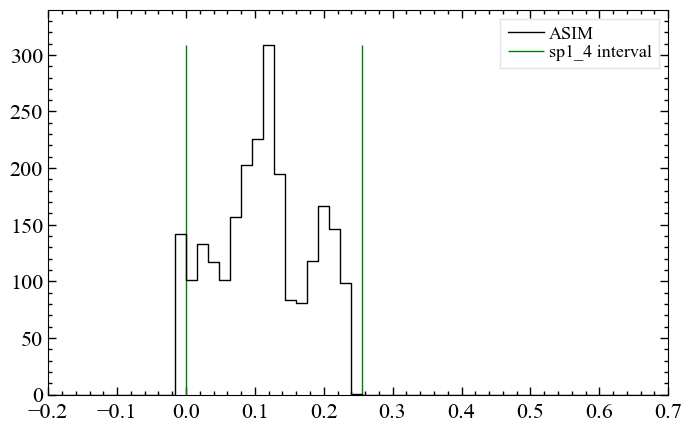

In [293]:
tus_asim = df_burst_final['tus'].to_numpy()

asim_counts, asim_edges = np.histogram(tus_asim, bins=bins)
plt.step(x=bins[:-1],y=asim_counts,where='pre',label='ASIM',c='black')
plt.vlines(x=[0.0,0.256],ymin=0,ymax=max(asim_counts),color='green',label='sp1_4 interval')
plt.ylim(bottom=0.0)
plt.xlim(left=-0.2, right=0.7)
plt.legend()
plt.show()

In [295]:
df_keV = keV_hist(df=df_burst_final,time_interval='max',keV_interval='max',convert_seconds=False)

Computing whole spectrum (10-1e5 keV)
n triggers in time interval  2379
n triggers are within bounds  2379
keV bins are set for HED
Energies binned!


In [296]:
bin_lo = df_keV['bins_keV'].to_numpy()[:-1]
bin_hi = df_keV['bins_keV'].to_numpy()[1:]
counts = df_keV['counts'].to_numpy()[1:]
err = df_keV['poisson_error_counts'].to_numpy()[1:]
len(bin_lo),len(bin_hi),len(counts),len(err)

(40, 40, 40, 40)

In [297]:
tus_burst = df_burst_final['tus'].to_numpy()

print('Exposure: ',np.round(tus_burst[-1]-tus_burst[0],4))
print(T0_asim)

Exposure:  0.2558
2020-07-16 22:57:39.931500


In [299]:
round(tus_burst[0],4)

0.0002

### PHA

In [204]:
grb_ra,grb_dec

(196.01, 29.636)

In [300]:
pha_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2020-07-16T22:57:39.931','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [0.000,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [0.256,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [0.2558,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB200716C','Name of the observed object'], #<str> 
    'RA_OBJ': [196.01,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [29.636,'[deg] Dec of source'], #<float>
    'BACKFILE': ['HED_GRB200716C.bak','Background FITS file'], #<str> ('example.bak')
    'RESPFILE': ['HED_GRB200716C.rsp','Response FITS file'], #<str> ('example.rsp')
    'FILENAME': ['HED_GRB200716C.pha','PHA filename'] #<str>  ('example.pha')
}
#More keys can be declated. Set generatePHA(see_template=True) to view avalible keys,values & comments from the template HDR's

In [301]:
generatePHA(PHA_dict=pha_dict,bin_lo=bin_lo,bin_hi=bin_hi,stat_err=err,counts=counts)

### BAK
    - using background found in trigger file

dau/det starting from index 1
tus array given in seconds
safety time:  0.22 % removed
sorted by tus (s)


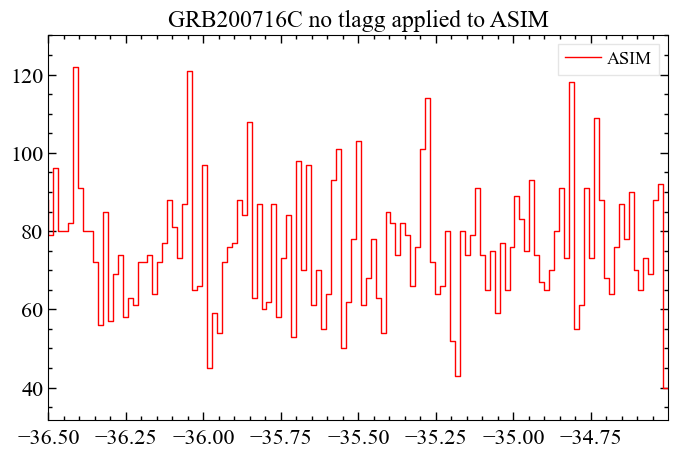

In [305]:
df_asim = harvest_data(fn='2020_7_16_22_57_40',T0='2020-07-16T22:57:40.634')
tus_asim = df_asim['tus'].to_numpy() + tlagg_asim
ix_asim = np.searchsorted(tus_asim,-2)
tus_asim_bak = tus_asim[:ix_asim]
df_asim_bak = df_asim.truncate(after=ix_asim-1)
bins_asim = np.arange(min(tus_asim_bak),max(tus_asim_bak)+binsize,binsize)
asim_counts_bak, asim_edges_bak = np.histogram(tus_asim_bak, bins=bins_asim)
plt.step(x=asim_edges_bak[:-1], y=asim_counts_bak, where='pre', label='ASIM',c='r')
plt.legend()
plt.title("GRB200716C no tlagg applied to ASIM")
plt.show()

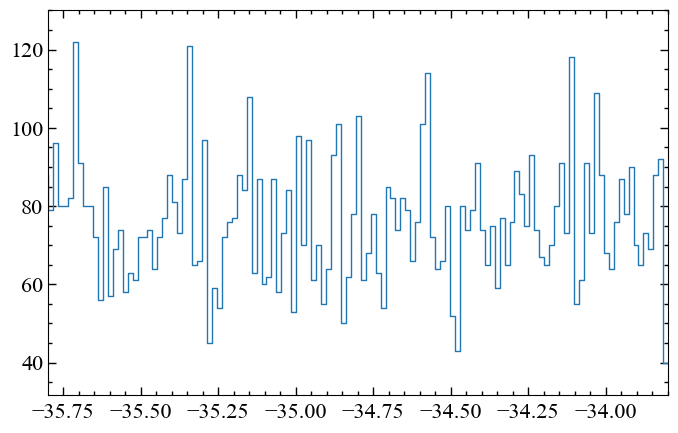

In [306]:
tus_asim_bkg = df_asim_bak['tus'].to_numpy()
bkg_counts,bkg_edges = np.histogram(tus_asim_bkg,bins=np.arange(min(tus_asim_bkg),max(tus_asim_bkg)+binsize,binsize))
plt.step(x=bkg_edges[:-1],y=bkg_counts)
plt.show()

In [307]:
df_kev_bkg = keV_hist(df_asim_bak,time_interval='max',keV_interval='max',convert_seconds=False)

Computing whole spectrum (10-1e5 keV)
n triggers in time interval  9563
n triggers are within bounds  9563
keV bins are set for HED
Energies binned!


In [308]:
print('Exposure bkg',np.round(tus_asim_bkg[-1]-tus_asim_bkg[0],4))
print('start',round(tus_asim_bkg[0],4))
print('end',round(tus_asim_bkg[-1],4))

Exposure bkg 2.0095
start -35.7981
end -33.7887


In [309]:
bak_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2020-07-16T22:57:39.931','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [-35.7981,'[s] Start time of background accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [-33.7887,'End time of background accumulation'], #<float> [s]
    'EXPOSURE': [2.0095,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB200716C','Name of the observed object'], #<str> 
    'RA_OBJ': [196.01,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [29.636,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB200716C.bak','Backgorund filename for fits file'] #<str>  ('example.bak')
}
#More keys can be declated. Set generatePHA(see_template=True) to view avalible keys,values & comments from the template HDR's

In [310]:
bak_counts = df_kev_bkg['counts'].to_numpy()[1:]
bak_err = df_kev_bkg['poisson_error_counts'].to_numpy()[1:]
bin_lo = df_kev_bkg['bins_keV'].to_numpy()[:-1]
bin_hi = df_kev_bkg['bins_keV'].to_numpy()[1:]

generateBAK(BAK_dict=bak_dict,bin_lo=bin_lo,bin_hi=bin_hi,bakCounts=bak_counts,stat_err=bak_err)

### RSP
    -generate new respone for each pha file, since exposure is varying (?)

In [302]:
rsp_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2020-07-16T22:57:39.931','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [0.000,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [0.256,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [0.256,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB200716C','Name of the observed object'], #<str> 
    'RA_OBJ': [196.01,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [29.636,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB200716C.rsp','RSP filename'] #<str>  ('example.pha')
}

In [303]:
theta,phi = 143.836, -140.012
drm_path = '/Users/andreas/phys/master/HED_DRM' #'/Home/siv30/wad005/master/HED_DRM/data'
drmfname = find_DRM_file(dir_path=drm_path,theta=theta,phi=phi)
print(drmfname)

HED_drm_mats_150.00_-135.00.txt


In [304]:
generateRSP(RSP_dict=rsp_dict,DRM_fname=drmfname,bin_lo=bin_lo,bin_hi=bin_hi,theta=theta,phi=phi)

## FERMI extraction
    -verified that TRIGTIME changed in new_tte.header

In [262]:
#need to create a new tte object, which is shifted by tlagg_kw_fermi
#%run /Home/siv30/wad005/master/GRB/xspec/FERMI/fermi_functions.ipynb
%run /Users/andreas/phys/master/GRB/xspec/FERMI/fermi_functions.ipynb

new_tte = createNewTTE(oldTTEObj=tte,tlagg=tlagg_fermi,binsize=binsize,unit=unit,obj='GRB181222B',grb_ra=grb_ra,grb_dec=grb_dec)
phaii = new_tte.to_phaii(bin_by_time, binsize) #puls height amplitude of second type ii. i: sum along columns, ii: for all channels

erange = (350, 1e5) #usually advised lower range. Standard passband
lc_data = phaii.to_lightcurve(energy_range=erange)

print('fitting background...')
bkgd_times = [(-200.0, -50.0), (150,250)] # where to extract the background
backfitter = BackgroundFitter.from_phaii(phaii, Polynomial, time_ranges=bkgd_times)
backfitter.fit(order=2) #increase order to 2 when you have a large interval 


All MAC paths are set!


<Figure size 800x500 with 0 Axes>


All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
FERMI functions loaded successfully!
tte shifted by -0.1834
new TTE object created
fitting background...


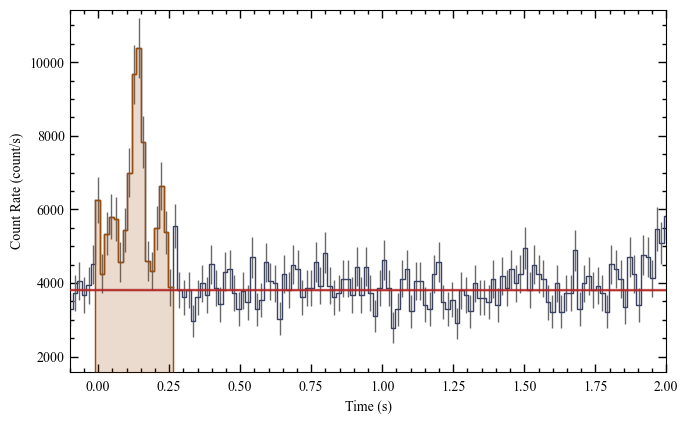

Normalised residuals: mean= 0.00075  std= 1.03
NormaltestResult(statistic=40.0373946142491, pvalue=2.0229736437918284e-09)


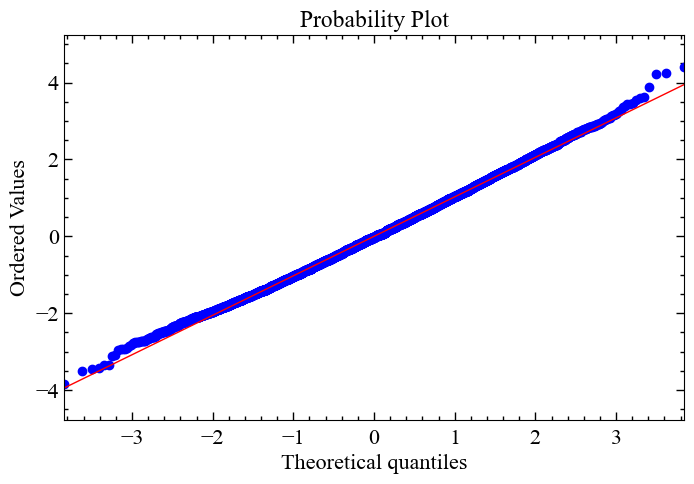

In [263]:
bkgd = backfitter.interpolate_bins(phaii.data.tstart, phaii.data.tstop)
lc_bkgd = bkgd.integrate_energy(*erange)
lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
src_time = (0.000,0.256)
view_range = (-0.1,2)
src_lc = phaii.to_lightcurve(time_range=src_time, energy_range=erange)
lcplot.xlim = view_range
lcplot.add_selection(src_lc)
plt.show()

# Define normalised residuals and test their compatibility with a standardized normal distribution
isel = np.where( ((lc_data.centroids>bkgd_times[0][0]) & (lc_data.centroids<bkgd_times[0][1])) | ((lc_data.centroids>bkgd_times[1][0]) & (lc_data.centroids<bkgd_times[1][1])) )[0]
isel_bkg = np.where( ((lc_bkgd.time_centroids>bkgd_times[0][0]) & (lc_bkgd.time_centroids<bkgd_times[0][1])) | ((lc_bkgd.time_centroids>bkgd_times[1][0]) & (lc_bkgd.time_centroids<bkgd_times[1][1])) )[0]
if np.all(isel == isel_bkg):
    norm_res = (lc_data.counts[isel]-lc_bkgd.counts[isel_bkg])/np.sqrt(lc_bkgd.counts[isel_bkg])
    print("Normalised residuals: mean= {:.3g}  std= {:.3g}".format(norm_res.mean(),norm_res.std()))
   # QQ plot to test normality
    import pylab 
    import scipy.stats as stats
    plt.cla()
    stats.probplot(norm_res, dist="norm",plot=pylab)
    from scipy.stats import normaltest
    print(normaltest(norm_res))
    plt.show()
#mu=0 std= 1 good, make sure the red line is not far frow the blue scatter plots

In [264]:
GRB_id = 'FERMI_GRB200716C'
src_time = (0.000,0.256)
pha = new_tte.to_pha(time_ranges=src_time)
# the background spectrum
bak = bkgd.to_bak(time_range=src_time)

# So now you have a PHA and BAK object which can be written as fully-formed FITS files using the `.write()` methods:
# ```python
fn_spectral = GRB_id + "_" + unit
bak.write('./', filename=fn_spectral+'.bak')
pha.write('./', filename=fn_spectral+'.pha', backfile=fn_spectral+'.bak')

# Read RSP function
rsp = RSP.open(fn_rsp)
# and interpolate response files to get DRMs at center of the source window
rsp_interp = rsp.interpolate(pha.tcent) #tcent central time of spectrum. interpolating the rsp at the time we specified

# Write response file
rsp_interp.write('./', filename=fn_spectral+'.rsp')

# It's advisable to set the RESPFILE keyword properly in the PHA file:
print("fparkey " + str(fn_spectral)+ ".rsp " + str(fn_spectral) + ".pha+2 RESPFILE")


fparkey FERMI_GRB200716C_b0.rsp FERMI_GRB200716C_b0.pha+2 RESPFILE
